# <span style="color:orange">Quality Data Analysis - Project Work </span>
## Team 69

### Course Details:
- Academic Year: 2023-2024

### Project Details:
- Title: Design a statistical process monitoring method for the in-line detection of defects

### Team Members:
- Sahar Dehghankhani 10975535
- Amirhossein Jandaghian 10964330
- Erica Nosotti 10648878
- Federico Bello XXXXXXXX

### Instructor:
- Bianca Maria Colosimo
- Panagiotis Tsiamyrtzi


## PHASE 1 - Report structure
Please use the following sections for your project report:
- **Introduction** [max 3500 characters including spaces]
    - Recap the project work framework and objective
    - Briefly summarize the overall methodology you used to model and analyse your data
    - Briefly summarize the state-of-the-art you analysed to support your study (if any).
- **Assumptions and preliminary data analysis** [max 5000 characters including spaces]
    - Clearly state and motivate all the assumptions your proposed methodology relies on; present and discuss any preliminary data analysis and visualization you applied on the data.
- **Proposed methodology** [max 10000 characters including spaces]
    - Synthetically describe, motivate and critically discuss your proposed statistical process monitoring approach.
- **Results** [max 10000 characters including spaces]
    - Synthetically presents and discuss the results of your statistical process monitoring design.

## PHASE 2 - Report structure
Please use the following sections for your project report:
- **Preliminary data analysis** [max 5000 characters including spaces]
    - Synthetically describe and discuss any preliminary data analysis and visualization applied on the new dataset.
- **Test of your proposed approach on new data** [max 5000 characters including spaces]
    - Synthetically presents and discuss the results you got applying to the new data your previously designed statistical process monitoring approach.
- **Discussion** [max 5000 characters including spaces]
    - Critically discuss your results In this Section you can also propose possible ways to tune or revise your previously designed method to enhance its defect detection performance.

You can add code cells to any of the above sections to show your code or display images. Each block of code should be accompanied by a brief description of what it does (not counted in characters limits).

## Submission
- Name your notebook as `teamXX.ipynb` where `XX` is your team number.
- Submit your notebook together with the Dataframe as a ZIP file on Webeep by the deadline. The ZIP file name must clearly state the "TEAM NUMBER".

# PHASE 1 ------------------------------


# Introduction

The project is based on designing a statistical process monitoring method for the in-line detection of defects affecting 3D parts printed by HP Multijet-Fusion process (material: PA12). The parts that have been analyzed are polymer PC fan covers.
The dataset consists of 40 samples, acquired by a machine in the laboratory. Each sample contains parts that are in-control, which means defect free.

First, the 10 images (each of which contains 4 samples) are extracted and analyzed in order to build reliable limits to use later to analyze images that may contain defected parts.
During the initial phase of our analysis, an image of each sample is extracted from the initial 10 images. Then these are  cropped, converted to greyscale and the contrast is increased. These operations are carried out with the objective of ensuring the accuracy and effectiveness of our subsequent analysis. Subsequently, we extract the necessary descriptive parameters to accurately describe the part. The parameters that we extracted are:
- External Area
- External Perimeter
- Voids area
- Voids perimeter
- Number of voids

To create our model we check the following assumption for all the descriptive statistics extracted:
1. Randomness through the runs test
2. Autocorrelation function
3. Normality with the Shapiro-Wilk test




# Assumptions and preliminary data analysis

Image collection took place at the MADE Competence Centre. The dataset acquisition strategy was chosen in collaboration with student representatives from other groups. It was decided to place the samples on the automatic line tray in groups of 4 (positioned with the same orientation). The acquisition carried out in this way has both positive and negative aspects: the model works with more pieces at a time, but the different positions and so the illumination made images different from the point of view of light/shadow balance. For this reason before the analysis, they were fixed and unified.

All proposed analyses and methodologies were implemented using Python; the following libraries were used:

- cv2
- matplotlib as mpl
- matplotlib.pyplot as plt
- numpy as np
- os
- pandas as pd
- seaborn as sns
- statsmodels.graphics.tsaplots as sgt
- from PIL import Image, ImageEnhance
- from scipy import stats
- from scipy.stats import shapiro
- from sklearn.decomposition import PCA
- from skimage.io import imsave
- from skimage.filters import threshold_otsu
- from skimage.measure import label, regionprops
- from statsmodels.sandbox.stats.runs import runstest_1samp
- from statsmodels.stats.diagnostic import acorr_ljungbox


For what concern the assumptions, these are refered in the code.

# Proposed Methodology

The proposed methodology is mainly based into three steps:

1. In the first step we take all the images and prepare them by cropping each one in 4 images, unifying and binarizing them.
In the following piece of code we prepare the images to be analyzed and plotted the obtained parameters.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns
import pandas as pd
from scipy import stats
import qda

# Set the colormap globally to 'viridis'
sns.set_theme()
mpl.rcParams['image.cmap'] = 'viridis'



ModuleNotFoundError: No module named 'qda'

In [ ]:
#functions of image data extraction & image display

def image_to_statistics(folder_path, output_folder):
    import os
    import cv2
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from PIL import Image, ImageEnhance
    from skimage.filters import threshold_otsu
    from skimage.measure import label, regionprops
    from skimage.io import imsave

    # Get a list of all the image files in the folder, ignoring hidden files and directories
    file_names = [f for f in os.listdir(folder_path) if not f.startswith(('.', '_', '-')) and os.path.isfile(os.path.join(folder_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

    # Initialize an empty list to store the statistics
    statistics = []

    # Define a function to get the quadrant of a point
    def get_quadrant(x, y, avg_x, avg_y):
        if y < avg_y and x < avg_x:
            return 0  # Top-left
        elif y >= avg_y and x < avg_x:
            return 1  # Bottom-left
        elif y < avg_y and x >= avg_x:
            return 2  # Top-right
        else:
            return 3  # Bottom-right

    # Define a function to get the quadrant name of a point
    def get_quadrant_name(x, y, avg_x, avg_y):
        if y < avg_y and x < avg_x:
            return "top_left"  # Top-left
        elif y >= avg_y and x < avg_x:
            return "bottom_left"  # Bottom-left
        elif y < avg_y and x >= avg_x:
            return "top_right"  # Top-right
        else:
            return "bottom_right"  # Bottom-right

    # Iterate over the image files and convert them to a list of arrays
    for idx, image_file in enumerate(file_names):
        # Open the image file
        image_path = os.path.join(folder_path, image_file)
        image = Image.open(image_path)

        # Convert the image to grayscale
        image = image.convert('L')

        # Increase the contrast
        enhancer = ImageEnhance.Contrast(image)
        image = enhancer.enhance(5)

        # Get dimensions
        width, height = image.size
        v_crop = 800
        o_crop = 1000

        # Check if the image is large enough to crop
        if width >= o_crop and height >= v_crop:
            # Determine the coordinates for a 1000x1000 square centered in the image
            left = (width - o_crop)/2
            top = (height - v_crop)/2
            right = (width + o_crop)/2
            bottom = (height + v_crop)/2

            # Crop the image and convert it to a numpy array
            image = image.crop((left, top, right, bottom))
            preprocessed_image = np.array(image)

            # Segment the image using Otsu's thresholding
            otsu_thresh = threshold_otsu(preprocessed_image)
            segmented_image = preprocessed_image > otsu_thresh

            # Label the connected components in the segmented image
            labeled_segmented_image = label(segmented_image)

            # Calculate the size of each component
            regions_segmented = regionprops(labeled_segmented_image)
            sizes = [r.area for r in regions_segmented]

            # Sort the components by size and keep only the largest ones
            largest_components = sorted([(i, s) for i, s in enumerate(sizes)], key=lambda x: x[1], reverse=True)[:4]
            largest_labels = [x[0] + 1 for x in largest_components]  # labels start from 1
            segmented_image = np.isin(labeled_segmented_image, largest_labels)

            # Extract the largest connected regions
            image_regions = []
            for lbl in largest_labels:
                region = (labeled_segmented_image == lbl)
                image_regions.append(region)

            # Get the centroid for each region
            image_regions_centroids = [regionprops(region.astype(int))[0].centroid for region in image_regions]

            # Calculate the average x and y coordinates
            avg_x = sum(c[1] for c in image_regions_centroids) / len(image_regions_centroids)
            avg_y = sum(c[0] for c in image_regions_centroids) / len(image_regions_centroids)

            # Sort the indices based on the quadrant
            sorted_indices = sorted(range(len(image_regions_centroids)), key=lambda k: get_quadrant(image_regions_centroids[k][1], image_regions_centroids[k][0], avg_x, avg_y))

            # Sort the regions and centroids based on the sorted indices
            image_regions = [image_regions[i] for i in sorted_indices]
            image_regions_centroids = [image_regions_centroids[i] for i in sorted_indices]

            # Assign names to the sorted regions
            for img_idx, img in enumerate(image_regions):

                # Get the quadrant name
                quadrant = get_quadrant_name(image_regions_centroids[img_idx][1], image_regions_centroids[img_idx][0], avg_x, avg_y)

                # Convert the boolean image to an 8-bit unsigned integer image
                img = (img.astype(np.uint8) * 255)
                # Use regionprops to get properties of the region
                part_props = regionprops(img)[0]  # Get the first (and only) region
                # Crop the image with margin around the bounding box
                minr, minc, maxr, maxc = part_props.bbox
                minr_crop = max(minr - 15, 0)
                minc_crop = max(minc - 15, 0)
                maxr_crop = min(maxr + 15, img.shape[0])
                maxc_crop = min(maxc + 15, img.shape[1])
                padded_img = img[minr_crop:maxr_crop, minc_crop:maxc_crop]
                # Save the padded image
                filename = f"{image_file}_{quadrant}_segmented.png"
                output_path = os.path.join(output_folder, filename)
                imsave(output_path, padded_img)

                # Invert the padded image
                inv_padded_img = 255 - padded_img
                # Apply labeling
                labels = label(inv_padded_img, background=0)
                props_voids = regionprops(labels)
                # Find the biggest region
                biggest_region = max(props_voids, key=lambda region: region.area)
                # Set the pixels in the biggest region to 0
                labels[labels == biggest_region.label] = 0
                # Repeat labeling
                labels = label(labels, background=0)
                props_voids = regionprops(labels)
                # Create a figure and axes
                fig, ax = plt.subplots()
                # Display the image
                ax.imshow(labels, cmap='nipy_spectral')
                # Annotate label numbers
                for region in regionprops(labels):
                    # Get the coordinates of the centroid
                    y, x = region.centroid
                    # Annotate the label number at the centroid
                    ax.text(x, y, str(region.label), color='white')
                # Save the labeled image
                labeled_filename = f"{image_file}_{quadrant}_labeled.png"
                labeled_output_path = os.path.join(output_folder, labeled_filename)
                plt.savefig(labeled_output_path)
                # Close the figure to free up memory
                plt.close(fig)

                # For each statistic in regionprops, create a row with Image name, Position, Region type, ID, and each metric
                statistics.append({
                    "Image name": image_file,
                    "Position": quadrant,
                    "Region type": "part",
                    "ID": 0,
                    "Area [pixels]": round(part_props.area, 3),
                    "Perimeter [pixels]": round(part_props.perimeter, 3),
                    "Eccentricity": round(part_props.eccentricity, 3),
                    "Orientation [radians]": round(part_props.orientation, 3),
                    "Solidity": round(part_props.solidity, 3),
                    "Extent": round(part_props.extent, 3),
                    "Major Axis Length [pixels]": round(part_props.major_axis_length, 3),
                    "Minor Axis Length [pixels]": round(part_props.minor_axis_length, 3),
                    "Equivalent Diameter [pixels]": round(part_props.equivalent_diameter, 3)
                })

                # Loop over each void
                for i, prop in enumerate(props_voids, start=1):
                    # For each statistic in regionprops, create a row with Image name, Position, Region type, ID, and each metric
                    statistics.append({
                        "Image name": image_file,
                        "Position": quadrant,
                        "Region type": "void",
                        "ID": i,
                        "Area [pixels]": round(prop.area, 3),
                        "Perimeter [pixels]": round(prop.perimeter, 3),
                        "Eccentricity": round(prop.eccentricity, 3),
                        "Orientation [radians]": round(prop.orientation, 3),
                        "Solidity": round(prop.solidity, 3),
                        "Extent": round(prop.extent, 3),
                        "Major Axis Length [pixels]": round(prop.major_axis_length, 3),
                        "Minor Axis Length [pixels]": round(prop.minor_axis_length, 3),
                        "Equivalent Diameter [pixels]": round(prop.equivalent_diameter, 3)
                    })

    # Convert the list of dictionaries to a DataFrame
    statistics_df = pd.DataFrame(statistics)

    return statistics_df


def display_images_with_names(image_folder, image_names):
      # Example usage:
      # display_images_with_names("/path/to/image_folder", ["image1.png", "image2.jpg"])
    import os
    from PIL import Image
    import matplotlib.pyplot as plt

    for image_name in image_names:
        image_path = os.path.join(image_folder, image_name)
        if os.path.exists(image_path):
            image = Image.open(image_path)
            plt.figure()
            plt.imshow(image)
            plt.title(image_name)
            plt.axis('off')
            plt.show()
        else:
            print(f"Image {image_name} not found in {image_folder}")


In [ ]:
#dataframe


file_path = '/content/drive/MyDrive/University |‌ دانشگاه/Masters - Polimi/AY23:24/Y 01/QDA Project/image_statistics.csv'
df = pd.read_csv(file_path, index_col=('Image name', 'Position'))

#after finaliztion
#df = image_to_statistics(folder_path, output_folder, 5)

parts =  df[df['ID'] == 0 ]
voids =  df[df['ID'] != 0 ]

df.head(5)

Region type  ID  \
Image name                                         Position                   
2024-03-26_14-19-54-164_MV540-H@xWyHvMbxwzDCYCH... top_left        part   0   
                                                   top_left        void   1   
                                                   top_left        void   2   
                                                   top_left        void   3   
                                                   top_left        void   4   

                                                             Area [pixels]  \
Image name                                         Position                  
2024-03-26_14-19-54-164_MV540-H@xWyHvMbxwzDCYCH... top_left        38468.0   
                                                   top_left           80.0   
                                                   top_left           54.0   
                                                   top_left          183.0   
                                                   top_left          166.0   

                                                             Perimeter [pixels]  \
Image name                                         Position                       
2024-03-26_14-19-54-164_MV540-H@xWyHvMbxwzDCYCH... top_left            4059.762   
                                                   top_left              42.142   
                                                   top_left              28.314   
                                                   top_left              61.799   
                                                   top_left              69.770   

                                                             Eccentricity  \
Image name                                         Position                 
2024-03-26_14-19-54-164_MV540-H@xWyHvMbxwzDCYCH... top_left         0.116   
                                                   top_left         0.950   
                                                   top_left         0.865   
                                                   top_left         0.902   
                                                   top_left         0.967   

                                                             Orientation [radians]  \
Image name                                         Position                          
2024-03-26_14-19-54-164_MV540-H@xWyHvMbxwzDCYCH... top_left                 -0.943   
                                                   top_left                 -1.303   
                                                   top_left                 -1.335   
                                                   top_left                 -1.413   
                                                   top_left                 -1.210   

                                                             Solidity  Extent  \
Image name                                         Position                     
2024-03-26_14-19-54-164_MV540-H@xWyHvMbxwzDCYCH... top_left     0.765   0.697   
                                                   top_left     0.860   0.526   
                                                   top_left     0.900   0.643   
                                                   top_left     0.906   0.587   
                                                   top_left     0.869   0.357   

                                                             Major Axis Length [pixels]  \
Image name                                         Position                               
2024-03-26_14-19-54-164_MV540-H@xWyHvMbxwzDCYCH... top_left                     275.986   
                                                   top_left                      18.844   
                                                   top_left                      12.049   
                                                   top_left                      24.715   
                                                   top_left                      30.780   

                            

In [ ]:
voids.describe()

,ID,Area [pixels],Perimeter [pixels],Eccentricity,Orientation [radians],Solidity,Extent,Major Axis Length [pixels],Minor Axis Length [pixels],Equivalent Diameter [pixels]
count,1789.0000,1789.0000,1789.0000,1789.0000,1789.0000,1789.0000,1789.0000,1789.0000,1789.0000,1789.0000
mean,22.9100,267.1688,67.3526,0.8237,0.1009,0.9135,0.5468,25.9560,13.0192,17.0970
std,12.9929,170.8372,27.7984,0.1821,0.9904,0.0502,0.1170,9.2675,6.8000,6.9201
min,1.0000,1.0000,0.0000,0.0000,-1.5700,0.6000,0.1910,0.0000,0.0000,1.1280
25%,12.0000,117.0000,48.9350,0.7760,-0.9520,0.8960,0.4920,20.5350,8.0160,12.2050
50%,23.0000,270.0000,76.9060,0.8850,0.2020,0.9270,0.5540,26.6360,12.9950,18.5410
75%,34.0000,386.0000,85.5270,0.9400,0.9440,0.9440,0.6030,32.1200,19.2790,22.1690
max,48.0000,697.0000,121.7400,1.0000,1.5710,1.0000,1.0000,46.1700,25.5060,29.7900


In [ ]:
parts.describe()

,ID,Area [pixels],Perimeter [pixels],Eccentricity,Orientation [radians],Solidity,Extent,Major Axis Length [pixels],Minor Axis Length [pixels],Equivalent Diameter [pixels]
count,40.0,40.0000,40.0000,40.0000,40.0000,40.0000,40.0000,40.0000,40.0000,40.0000
mean,0.0,38317.3250,4181.6875,0.1132,-0.4819,0.7569,0.7135,278.1258,276.1687,220.8738
std,0.0,483.7254,95.4208,0.0350,0.7980,0.0097,0.0195,1.4244,1.5413,1.3939
min,0.0,37273.0000,3928.6790,0.0270,-1.5460,0.7360,0.6730,274.7530,271.4350,217.8470
25%,0.0,38059.0000,4122.7188,0.1065,-0.9472,0.7518,0.7017,276.9720,275.6895,220.1325
50%,0.0,38299.0000,4196.8330,0.1200,-0.6310,0.7555,0.7160,278.4250,276.4675,220.8255
75%,0.0,38593.2500,4263.9937,0.1355,-0.5132,0.7620,0.7290,279.4965,277.0827,221.6718
max,0.0,39386.0000,4306.7860,0.1640,1.5470,0.7850,0.7470,280.1990,278.1420,223.9370



The team proceeds the analysis by extracting some descriptive properties of the images.                                 
In the subsequent piece of code we reported the calculations for the following parameters:
- External Area : Part_Area
- External Perimeter : Part_Perimeter
- Voids area : Voids_Area
- Voids perimeter : Voids_Perimeter
- Number of voids : #Voids

In [ ]:
parts_measures = parts[['Area [pixels]', 'Perimeter [pixels]']]
parts_measures.columns = ['Part_Area', 'Part_Perimeter']

no_of_voids = voids.groupby(['Image name', 'Position']).max()['ID']
s_voids_area = voids.groupby(['Image name', 'Position'])['Area [pixels]'].mean()
s_voids_perimeter = voids.groupby(['Image name', 'Position'])['Perimeter [pixels]'].mean()

parts_measures = parts_measures.merge(s_voids_area, how='left', on=('Image name', 'Position')).merge(s_voids_perimeter, how='left', on=('Image name', 'Position')).merge(no_of_voids, how='left', on=('Image name', 'Position'))
parts_measures.columns =['Part_Area', 'Part_Perimeter', 'Voids_Area', 'Voids_Perimeter' ,'#Voids']
parameters = ['Part_Area', 'Part_Perimeter', 'Voids_Area', 'Voids_Perimeter' ,'#Voids']
parts_measures.head()

Part_Area  \
Image name                                         Position                  
2024-03-26_14-19-54-164_MV540-H@xWyHvMbxwzDCYCH... top_left        38468.0   
                                                   bottom_left     39106.0   
                                                   top_right       38293.0   
                                                   bottom_right    38200.0   
2024-03-26_14-12-22-903_MV540-H@xWyHvMbxwzDCYCH... top_left        38411.0   

                                                                 Part_Perimeter  \
Image name                                         Position                       
2024-03-26_14-19-54-164_MV540-H@xWyHvMbxwzDCYCH... top_left            4059.762   
                                                   bottom_left         4086.620   
                                                   top_right           4122.076   
                                                   bottom_right        4119.247   
2024-03-26_14-12-22-903_MV540-H@xWyHvMbxwzDCYCH... top_left            4170.963   

                                                                 Voids_Area  \
Image name                                         Position                   
2024-03-26_14-19-54-164_MV540-H@xWyHvMbxwzDCYCH... top_left        264.7907   
                                                   bottom_left     264.2791   
                                                   top_right       244.1304   
                                                   bottom_right    243.0417   
2024-03-26_14-12-22-903_MV540-H@xWyHvMbxwzDCYCH... top_left        277.0682   

                                                                 Voids_Permeter  \
Image name                                         Position                       
2024-03-26_14-19-54-164_MV540-H@xWyHvMbxwzDCYCH... top_left             67.5437   
                                                   bottom_left          67.9381   
                                                   top_right            64.0336   
                                                   bottom_right         61.2292   
2024-03-26_14-12-22-903_MV540-H@xWyHvMbxwzDCYCH... top_left             68.5917   

                                                                 #Voids  
Image name                                         Position              
2024-03-26_14-19-54-164_MV540-H@xWyHvMbxwzDCYCH... top_left          43  
                                                   bottom_left       43  
                                                   top_right         46  
                                                   bottom_right      48  
2024-03-26_14-12-22-903_MV540-H@xWyHvMbxwzDCYCH... top_left          44

Now the datas are plotted.


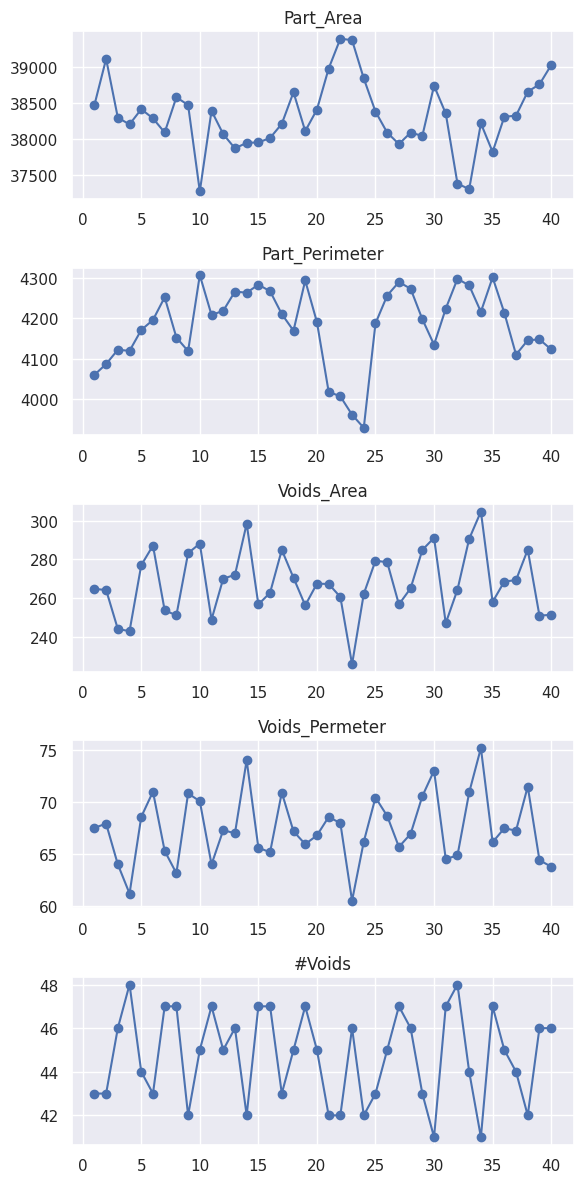

In [ ]:
#plot the data
fig, axs = plt.subplots(len(parameters), 1, figsize=(6, 12))

# Loop through each column name and plot the corresponding column
for i, colname in enumerate(parameters):
    x = range(1, len(parts_measures[colname]) + 1)  # Range of numbers for x-axis
    axs[i].plot(x, parts_measures[colname], 'o-')
    axs[i].set_title(colname)  # Set title for each subplot

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


2. Now the team proceed with the analysis by checking the assumptions of randomness and normality, also plotting the autocorrelation function. We repeate this procedure for all the previous parameters.

In [ ]:
# Verify if the data are random with runs test
# Import the necessary libraries for the runs test
from statsmodels.sandbox.stats.runs import runstest_1samp

alpha = 0.05

for parameter in parameters:
      _, pval_runs = runstest_1samp(parts_measures[parameter], correction=False)

      print('{}: Runs test p-value is {:.3f}'.format(parameter, pval_runs))
      if pval_runs < alpha:
          print('Not-Random ❌')
      else:
          print('Random ✅')

      print('')


Part_Area: Runs test p-value is 0.056
Random ✅

Part_Perimeter: Runs test p-value is 0.002
Not-Random ❌

Voids_Area: Runs test p-value is 0.219
Random ✅

Voids_Permeter: Runs test p-value is 0.698
Random ✅

#Voids: Runs test p-value is 0.857
Random ✅



All the parameters are assessed as random, except the 'Part_Perimeter'.

Part_Area: LBQ test p-value is 0.008
data are Autocorrolated ❌


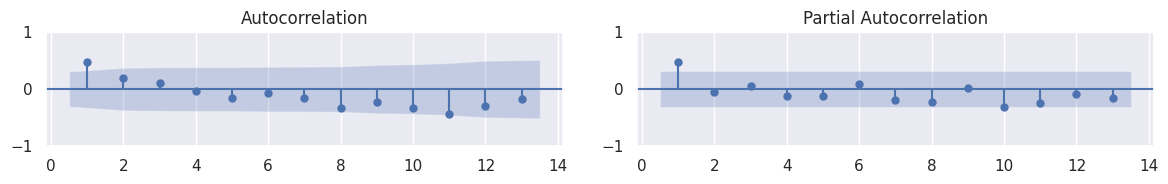



Part_Perimeter: LBQ test p-value is 0.001
data are Autocorrolated ❌


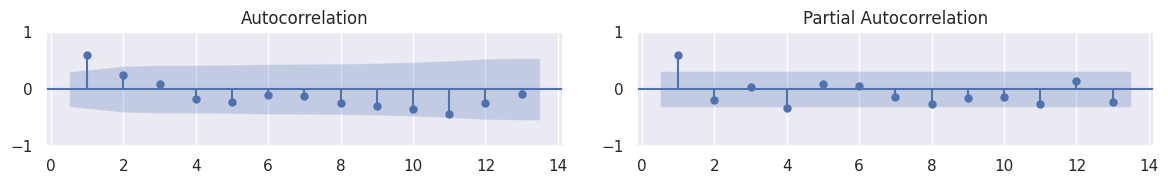



Voids_Area: LBQ test p-value is 0.000
data are Autocorrolated ❌


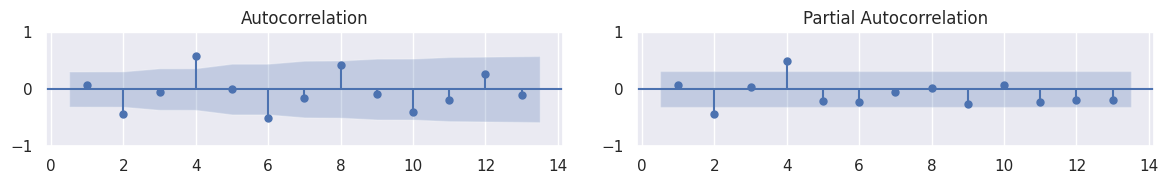



Voids_Permeter: LBQ test p-value is 0.000
data are Autocorrolated ❌


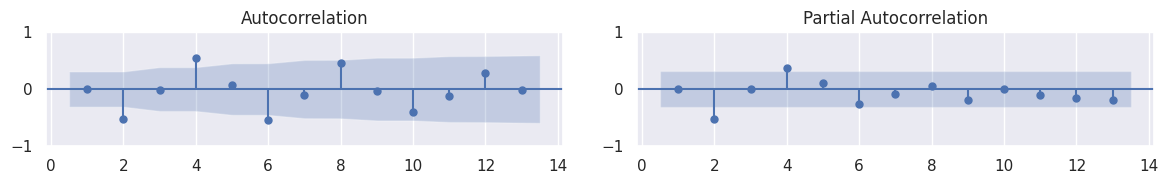



#Voids: LBQ test p-value is 0.000
data are Autocorrolated ❌


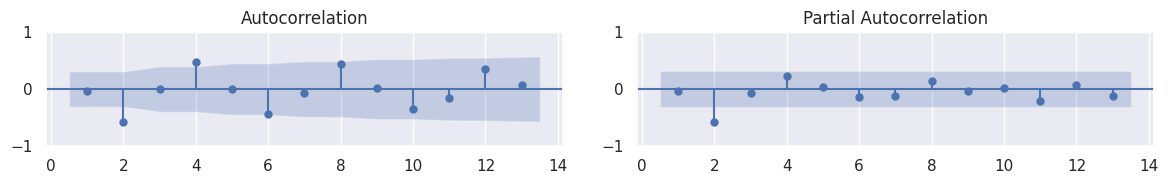

In [ ]:
# Plot the acf and pacf using the statsmodels library
import statsmodels.graphics.tsaplots as sgt
from statsmodels.stats.diagnostic import acorr_ljungbox


for parameter in parameters:

      #LBQ test for autocorrelation
      lbq_test = acorr_ljungbox(parts_measures[parameter], lags= 8 , return_df=True)
      pval_lbq = lbq_test.loc[8,'lb_pvalue']

      print('{}: LBQ test p-value is {:.3f}'.format(parameter, pval_lbq))
      if pval_lbq < alpha:
          print('data are Autocorrolated ❌')
      else:
          print('data are not Autocorrolated ✅')

      fig, ax = plt.subplots(1,2 , figsize = (12, 2))
      sgt.plot_acf(parts_measures[parameter], lags = int(len(parts_measures[parameter])/3), zero=False, ax=ax[0])
      fig.subplots_adjust(hspace=0.5)
      sgt.plot_pacf(parts_measures[parameter] , lags = int(len(parts_measures[parameter])/3), zero=False, ax=ax[1], method = 'ywm')

      plt.tight_layout()
      plt.show()

      print('\n')

All the data of the parameter statistics seems to be not autocorrelated.

Part_Area: Shapiro test p-value is 0.355
Normal distribution ✅


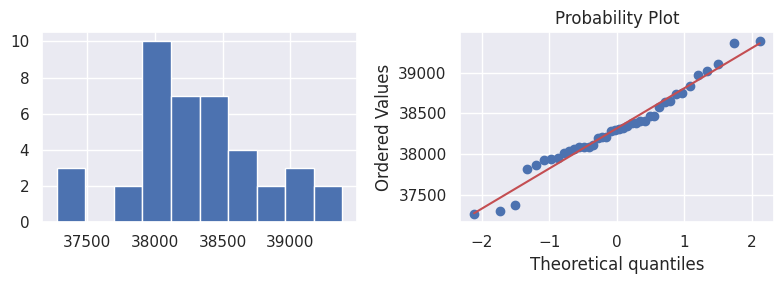


-------------------
Part_Perimeter: Shapiro test p-value is 0.017
Not Normal ❌


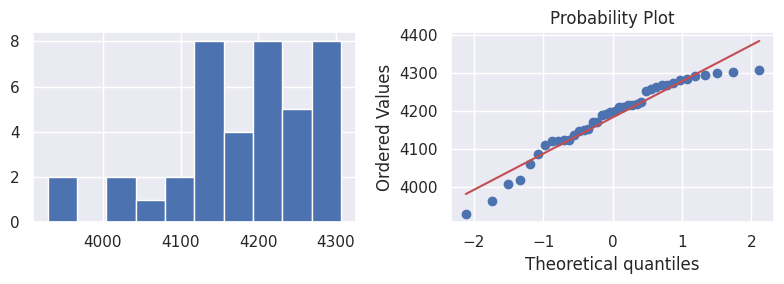


-------------------
Voids_Area: Shapiro test p-value is 0.924
Normal distribution ✅


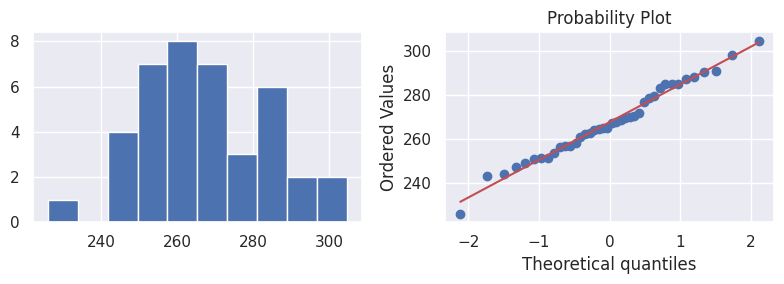


-------------------
Voids_Permeter: Shapiro test p-value is 0.797
Normal distribution ✅


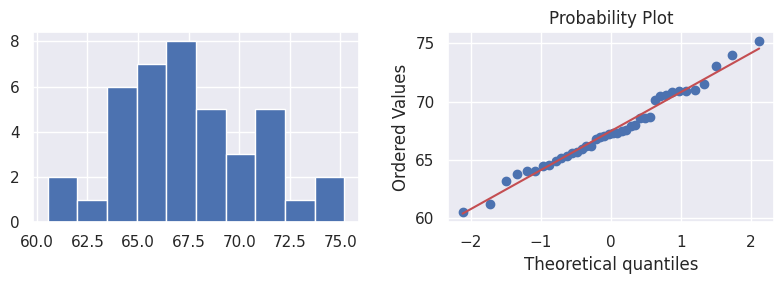


-------------------
#Voids: Shapiro test p-value is 0.008
Not Normal ❌


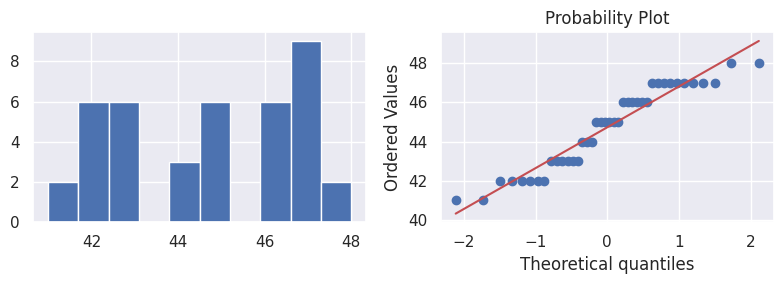


-------------------


In [ ]:
#Shapiro-Wilk test for all parameters
from scipy import stats
from scipy.stats import shapiro

alpha = 0.05

for parameter in parameters:
    statistic, p_value = shapiro(parts_measures[parameter])
    print('{}: Shapiro test p-value is {:.3f}'.format(parameter, p_value))

    if p_value < alpha:
        print('Not Normal ❌')
    else:
        print('Normal distribution ✅')


    # Plot of histogram and probability plot
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    axs[0].hist(parts_measures[parameter])
    stats.probplot(parts_measures[parameter], dist="norm", plot=axs[1])
    plt.tight_layout()
    plt.show()
    print('\n-------------------')



As we can see from the graphs, the parameters 'Part_Perimeter' and '#Voids' don't follow the normal distribution.

So, we decided to do a Box-Cox on these two parameters and then recheck the assumption of normality.

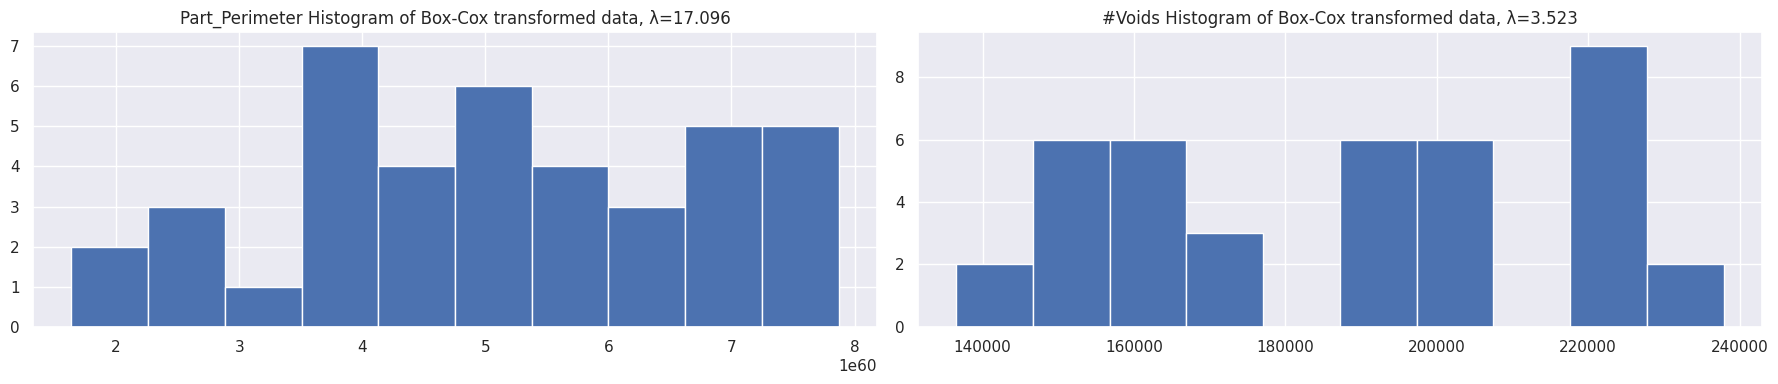

In [ ]:
violating_measures = ['Part_Perimeter', '#Voids']

#Box Cox
fig, ax = plt.subplots(1, len(violating_measures), figsize=(18, 4))


lambdas = {}

for i, parameter in enumerate(violating_measures):
      # Box-Cox transformation
      data_norm, lmbda = stats.boxcox(parts_measures[parameter])
      parts_measures[f'{parameter}_Normal'] = data_norm
      lambdas[parameter] = lmbda  # Store the lambda value
      ax[i].hist(data_norm)
      ax[i].set_title('{} Histogram of Box-Cox transformed data, λ={:.3f}'.format(parameter, lmbda))

# Adjust layout
plt.tight_layout()
plt.show()



In [ ]:
#New set of parameter
new_parameters = ['Part_Area', 'Part_Perimeter_Normal', 'Voids_Area', 'Voids_Permeter', '#Voids_Normal']
parts_measures[new_parameters].head()

Part_Area  \
Image name                                         Position                  
2024-03-26_14-19-54-164_MV540-H@xWyHvMbxwzDCYCH... top_left        38468.0   
                                                   bottom_left     39106.0   
                                                   top_right       38293.0   
                                                   bottom_right    38200.0   
2024-03-26_14-12-22-903_MV540-H@xWyHvMbxwzDCYCH... top_left        38411.0   

                                                                 Part_Perimeter_Normal  \
Image name                                         Position                              
2024-03-26_14-19-54-164_MV540-H@xWyHvMbxwzDCYCH... top_left                 2.8671e+60   
                                                   bottom_left              3.2092e+60   
                                                   top_right                3.7199e+60   
                                                   bottom_right             3.6765e+60   
2024-03-26_14-12-22-903_MV540-H@xWyHvMbxwzDCYCH... top_left                 4.5506e+60   

                                                                 Voids_Area  \
Image name                                         Position                   
2024-03-26_14-19-54-164_MV540-H@xWyHvMbxwzDCYCH... top_left        264.7907   
                                                   bottom_left     264.2791   
                                                   top_right       244.1304   
                                                   bottom_right    243.0417   
2024-03-26_14-12-22-903_MV540-H@xWyHvMbxwzDCYCH... top_left        277.0682   

                                                                 Voids_Permeter  \
Image name                                         Position                       
2024-03-26_14-19-54-164_MV540-H@xWyHvMbxwzDCYCH... top_left             67.5437   
                                                   bottom_left          67.9381   
                                                   top_right            64.0336   
                                                   bottom_right         61.2292   
2024-03-26_14-12-22-903_MV540-H@xWyHvMbxwzDCYCH... top_left             68.5917   

                                                                 #Voids_Normal  
Image name                                         Position                     
2024-03-26_14-19-54-164_MV540-H@xWyHvMbxwzDCYCH... top_left        161460.6524  
                                                   bottom_left     161460.6524  
                                                   top_right       204766.3493  
                                                   bottom_right    237891.5539  
2024-03-26_14-12-22-903_MV540-H@xWyHvMbxwzDCYCH... top_left        175082.5901

In [ ]:
#Shapiro-Wilk test for all parameters

alpha = 0.05

for parameter in new_parameters:
    statistic, p_value = shapiro(parts_measures[parameter])
    print('{}: Shapiro test p-value is {:.3f}'.format(parameter, p_value))

    if p_value < alpha:
        print('Not Normal ❌')
    else:
        print('Normal distribution ✅')
    print('\n-------------------')

Part_Area: Shapiro test p-value is 0.355
Normal distribution ✅

-------------------
Part_Perimeter_Normal: Shapiro test p-value is 1.000
Normal distribution ✅

-------------------
Voids_Area: Shapiro test p-value is 0.924
Normal distribution ✅

-------------------
Voids_Permeter: Shapiro test p-value is 0.797
Normal distribution ✅

-------------------
#Voids_Normal: Shapiro test p-value is 0.009
Not Normal ❌

-------------------


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1877: RuntimeWarning: overflow encountered in cast
  a, w, pw, ifault = _statlib.swilk(y, a[:N//2], init)


As we can see, after the Box-Cox the 'Part_Perimeter' becomes normal, while the '#Voids' doesn't. Consequently, the team decided to remove the '#Voids' from the considered parameters.

In the next lines of code, we report the check of randomness and autocorrelation for the parameters after the Box-Cox.


In [ ]:
new_parameters = ['Part_Area', 'Part_Perimeter_Normal', 'Voids_Area', 'Voids_Permeter']

In [ ]:
alpha = 0.05

for parameter in new_parameters:
      _, pval_runs = runstest_1samp(parts_measures[parameter], correction=False)

      print('{}: Runs test p-value is {:.3f}'.format(parameter, pval_runs))
      if pval_runs < alpha:
          print('Not-Random ❌')
      else:
          print('Random ✅')

      print('\n-------------------')


Part_Area: Runs test p-value is 0.056
Random ✅

-------------------
Part_Perimeter_Normal: Runs test p-value is 0.001
Not-Random ❌

-------------------
Voids_Area: Runs test p-value is 0.219
Random ✅

-------------------
Voids_Permeter: Runs test p-value is 0.698
Random ✅

-------------------


Part_Area: LBQ test p-value is 0.008
data are Autocorrolated ❌


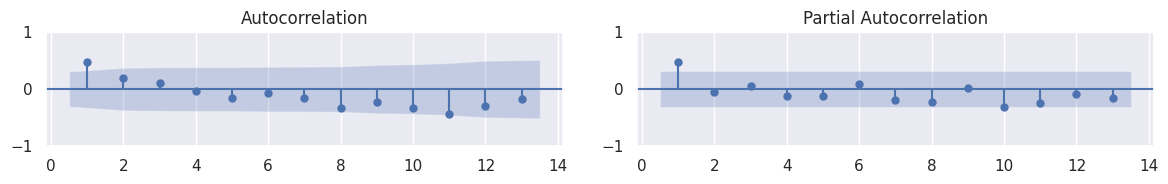


-------------------
Part_Perimeter_Normal: LBQ test p-value is 0.009
data are Autocorrolated ❌


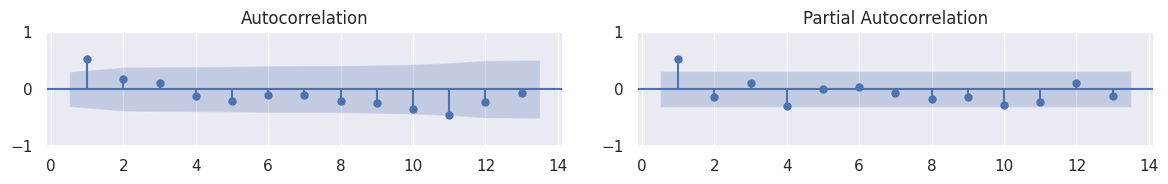


-------------------
Voids_Area: LBQ test p-value is 0.000
data are Autocorrolated ❌


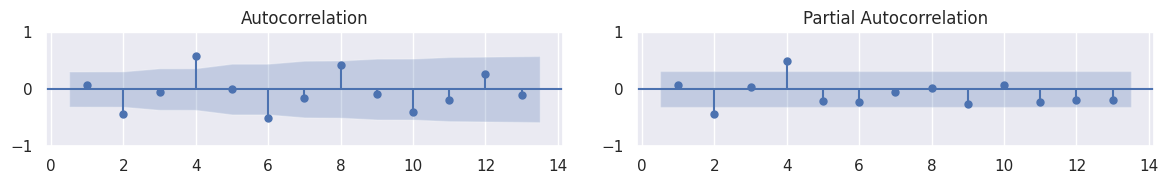


-------------------
Voids_Permeter: LBQ test p-value is 0.000
data are Autocorrolated ❌


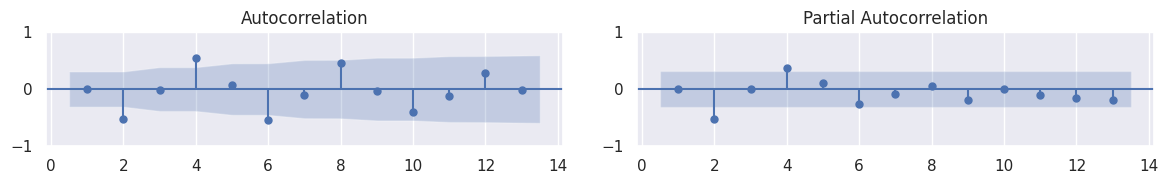


-------------------


In [ ]:

for parameter in new_parameters:

      #LBQ test for autocorrelation
      lbq_test = acorr_ljungbox(parts_measures[parameter], lags= 8 , return_df=True)
      pval_lbq = lbq_test.loc[8,'lb_pvalue']

      print('{}: LBQ test p-value is {:.3f}'.format(parameter, pval_lbq))
      if pval_lbq < alpha:
          print('data are Autocorrolated ❌')
      else:
          print('data are not Autocorrolated ✅')

      fig, ax = plt.subplots(1,2 , figsize = (12, 2))
      sgt.plot_acf(parts_measures[parameter], lags = int(len(parts_measures[parameter])/3), zero=False, ax=ax[0])
      fig.subplots_adjust(hspace=0.5)
      sgt.plot_pacf(parts_measures[parameter] , lags = int(len(parts_measures[parameter])/3), zero=False, ax=ax[1], method = 'ywm')

      plt.tight_layout()
      plt.show()

      print('\n-------------------')


Then we plotted a pairplot and a heatmap to better visualize the correlation relationships between the parameters.

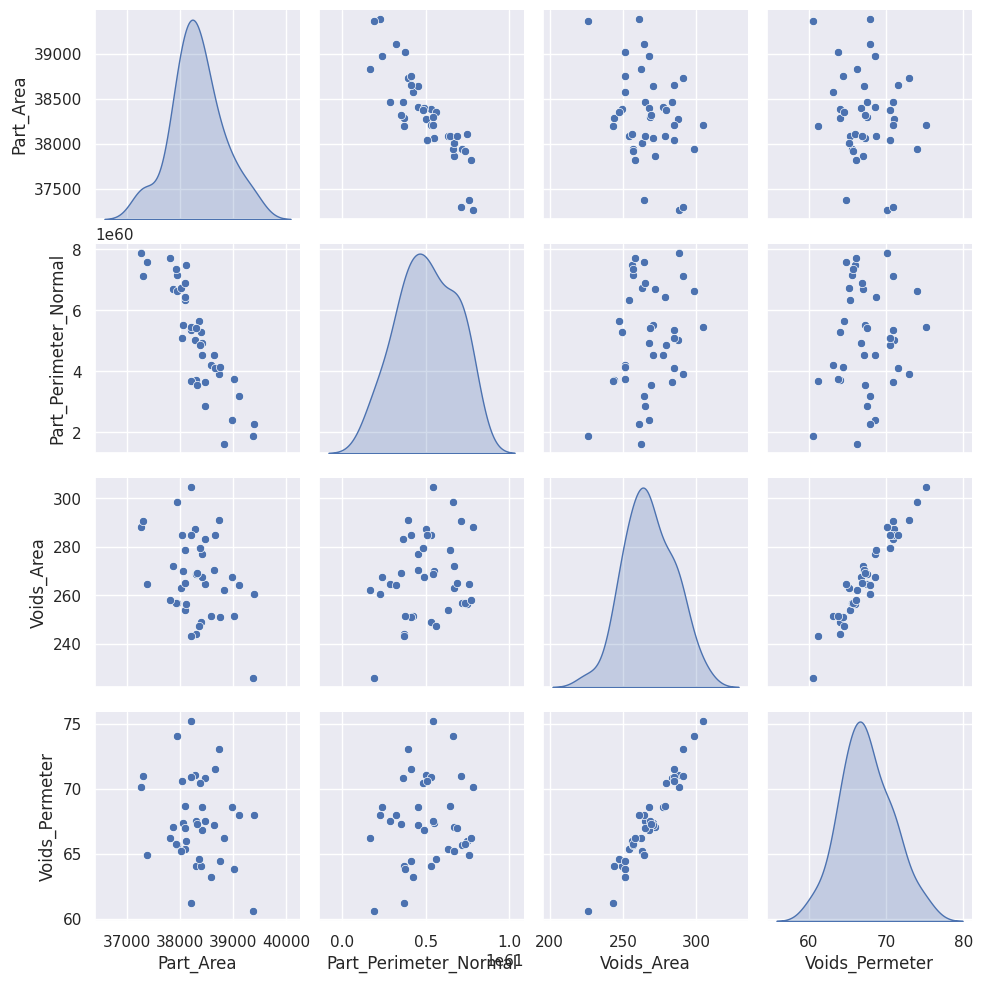

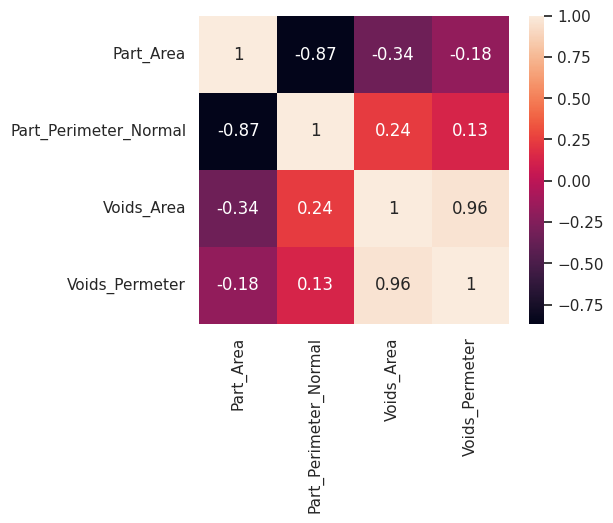

In [ ]:
sns.pairplot(parts_measures[new_parameters], diag_kind='kde')
plt.show()


plt.figure(figsize=(5, 4))
sns.heatmap(parts_measures[new_parameters].corr(), annot=True )
plt.show()

3. To have a second (perhaps more precise) check the team decided to do PCA. The code than creates a DataFrame with the first two principal components and plot them.

Eigenvalues 
 [2.3635 1.4778 0.1366 0.0221]

Eigenvectors 
 [[ 0.4918 -0.454  -0.5515 -0.4978]
 [ 0.4959 -0.5499  0.4257  0.52  ]
 [-0.6833 -0.6929  0.1315 -0.1888]
 [-0.2127 -0.1061 -0.7052  0.668 ]]

Explained variance ratio 
 [0.5909 0.3694 0.0341 0.0055]

Cumulative explained variance ratio 
 [0.5909 0.9603 0.9945 1.    ]


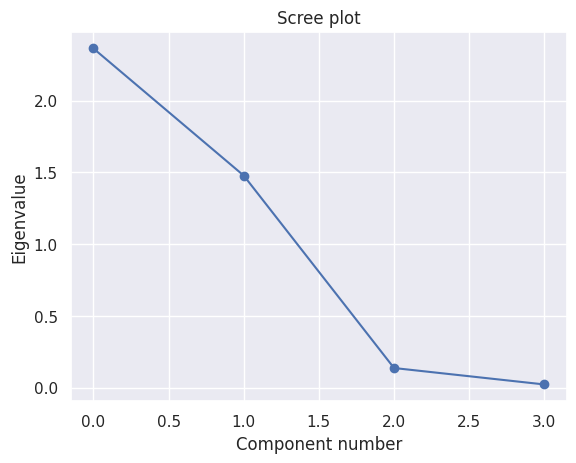

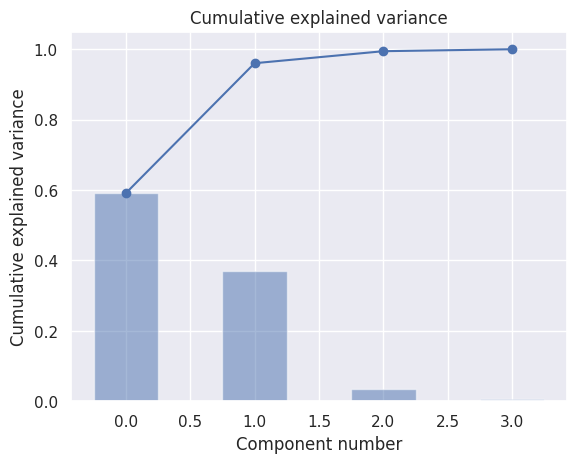

In [ ]:
# PCA

parts_measures_std = parts_measures[new_parameters]
parts_measures_std = (parts_measures_std - parts_measures_std.mean())/ parts_measures_std.std()


# import the libraries for PCA
from sklearn.decomposition import PCA


# Create the PCA object
pca_std = PCA()
# Fit the PCA object to the data
pca_std.fit(parts_measures_std)
# Print the eigenvalues
print("Eigenvalues \n", pca_std.explained_variance_)
# Print the eigenvectors
print("\nEigenvectors \n", pca_std.components_)
# Print the explained variance ratio
print("\nExplained variance ratio \n", pca_std.explained_variance_ratio_)
# Print the cumulative explained variance ratio
print("\nCumulative explained variance ratio \n", np.cumsum(pca_std.explained_variance_ratio_))


# Plot the eigenvalues (scree plot)
plt.plot(pca_std.explained_variance_, 'o-')
plt.xlabel('Component number')
plt.ylabel('Eigenvalue')
plt.title('Scree plot')
plt.show()

# Plot the cumulative explained variance
plt.plot(np.cumsum(pca_std.explained_variance_ratio_), 'o-')
# add a bar chart to the plot
plt.bar(range(0, len(pca_std.explained_variance_ratio_)), pca_std.explained_variance_ratio_, width = 0.5, alpha=0.5, align='center')
plt.xlabel('Component number')
plt.ylabel('Cumulative explained variance')
plt.title('Cumulative explained variance')
plt.show()

In [ ]:
# Compute the scores
scores = pca_std.transform(parts_measures_std)
# create a dataframe with the scores
scores_df = pd.DataFrame(scores, columns = ['z1', 'z2', 'z3', 'z4'])

parts_final_df = scores_df[['z1' , 'z2']]

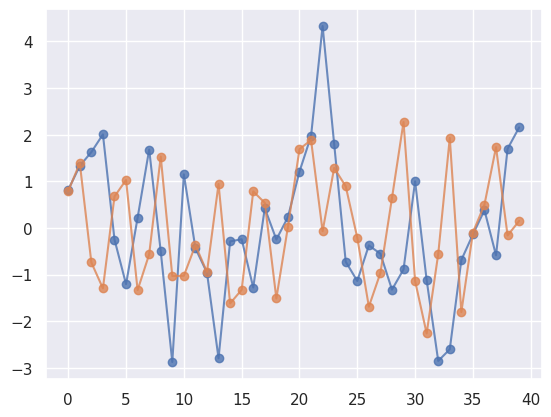

In [ ]:
#z1 plot
plt.plot(parts_final_df, 'o-', alpha=0.8)
plt.show()


For the first two principal components (z1 and z2) the normality, randomness and autocorrelation and analyzed.

Z1: Shapiro test p-value is 0.218
Normal distribution ✅

-------------------
Z1: Runs test p-value is 0.069
Random ✅

-------------------
Z1: LBQ test p-value is 0.039
data are Autocorrolated ❌


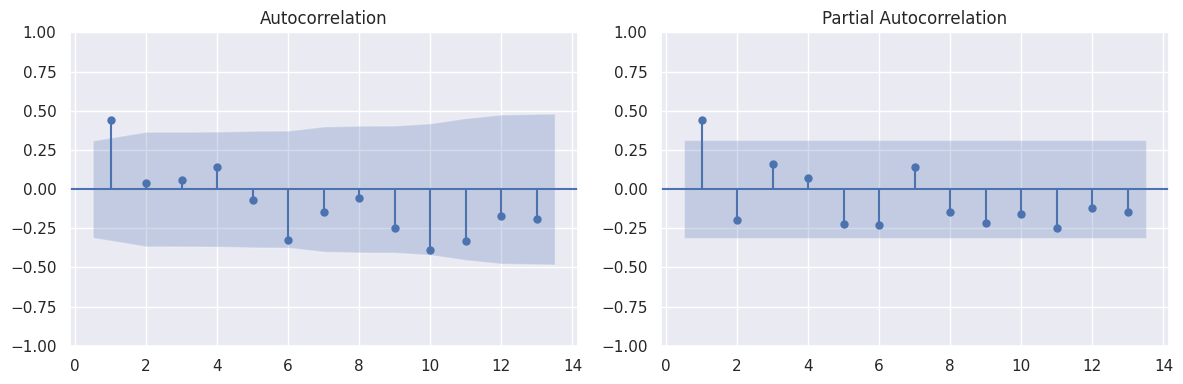


-------------------


In [ ]:
#z1

#Normality - Shapiro
statistic, p_value = shapiro(parts_final_df['z1'])
print('{}: Shapiro test p-value is {:.3f}'.format('Z1', p_value))

if p_value < alpha:
    print('Not Normal ❌')
else:
    print('Normal distribution ✅')
print('\n-------------------')

#RUN
_, pval_runs = runstest_1samp(parts_final_df['z1'], correction=False)

print('{}: Runs test p-value is {:.3f}'.format('Z1', pval_runs))
if pval_runs < alpha:
    print('Not-Random ❌')
else:
    print('Random ✅')

print('\n-------------------')

#LBQ
lbq_test = acorr_ljungbox(parts_final_df['z1'] , lags= 8 , return_df=True)
pval_lbq = lbq_test.loc[8,'lb_pvalue']

print('{}: LBQ test p-value is {:.3f}'.format('Z1', pval_lbq))
if pval_lbq < alpha:
    print('data are Autocorrolated ❌')
else:
    print('data are not Autocorrolated ✅')

fig, ax = plt.subplots(1,2 , figsize = (12, 4))
sgt.plot_acf(parts_final_df['z1'], lags = int(len(parts_final_df['z1'])/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(parts_final_df['z1'] , lags = int(len(parts_final_df['z1'])/3), zero=False, ax=ax[1], method = 'ywm')

plt.tight_layout()
plt.show()

print('\n-------------------')

Z2: Shapiro test p-value is 0.268
Normal distribution ✅

-------------------
Z2: Runs test p-value is 0.987
Random ✅

-------------------
Z2: LBQ test p-value is 0.001
data are Autocorrolated ❌


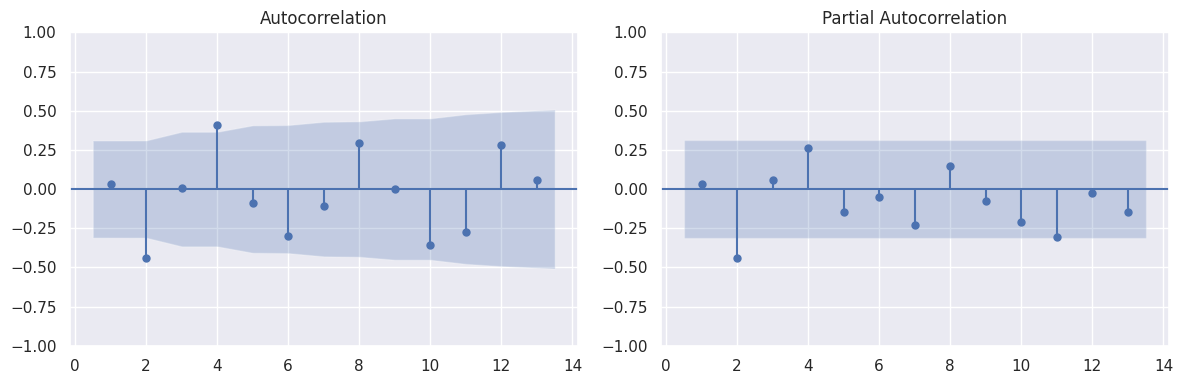


-------------------


In [ ]:
#z2

#Normality - Shapiro
statistic, p_value = shapiro(parts_final_df['z2'])
print('{}: Shapiro test p-value is {:.3f}'.format('Z2', p_value))

if p_value < alpha:
    print('Not Normal ❌')
else:
    print('Normal distribution ✅')
print('\n-------------------')

#RUN
_, pval_runs = runstest_1samp(parts_final_df['z2'], correction=False)

print('{}: Runs test p-value is {:.3f}'.format('Z2', pval_runs))
if pval_runs < alpha:
    print('Not-Random ❌')
else:
    print('Random ✅')

print('\n-------------------')

#LBQ
lbq_test = acorr_ljungbox(parts_final_df['z2'] , lags= 8 , return_df=True)
pval_lbq = lbq_test.loc[8,'lb_pvalue']

print('{}: LBQ test p-value is {:.3f}'.format('Z2', pval_lbq))
if pval_lbq < alpha:
    print('data are Autocorrolated ❌')
else:
    print('data are not Autocorrolated ✅')

fig, ax = plt.subplots(1,2 , figsize = (12, 4))
sgt.plot_acf(parts_final_df['z2'], lags = int(len(parts_final_df['z1'])/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(parts_final_df['z2'] , lags = int(len(parts_final_df['z1'])/3), zero=False, ax=ax[1], method = 'ywm')

plt.tight_layout()
plt.show()

print('\n-------------------')

z1 and z2 have both a normal distribution, are random and thier datas are  autocorrelated.


Lastly, we performed the ARIMA model analysis on the two principal component (z1 and z2) obtained from the previous PCA. Next, we test the residuals for normality and autocorrelation, and finally displays some characteristics of the residuals.


---------------------
ARIMA MODEL RESULTS
---------------------
ARIMA model order: p=1, d=0, q=0

FINAL ESTIMATES OF PARAMETERS
-------------------------------
 Term   Coef  SE Coef  T-Value  P-Value
ar.L1 0.4569   0.1453   3.1453   0.0017

RESIDUAL SUM OF SQUARES
-------------------------
  DF      SS     MS
39.0 72.5497 1.8602

Ljung-Box Chi-Square Statistics
----------------------------------
 Lag  Chi-Square  P-Value
  12     19.3506   0.0804
  24     37.2238   0.0416
  36     52.8507   0.0347
None
residuals: Shapiro test p-value is 0.757
Normal distribution ✅


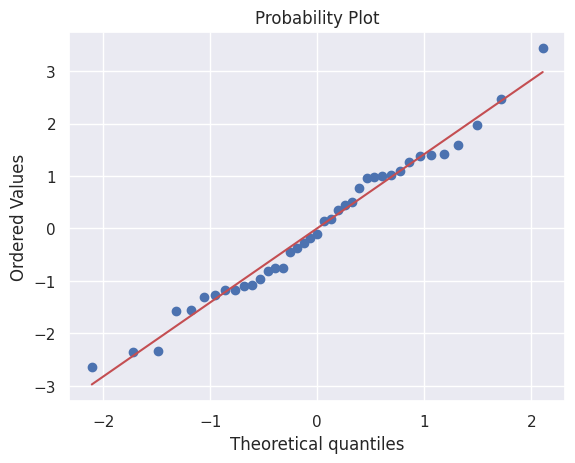


-------------------
Z1: LBQ test p-value is 0.119
data are not Autocorrolated ✅


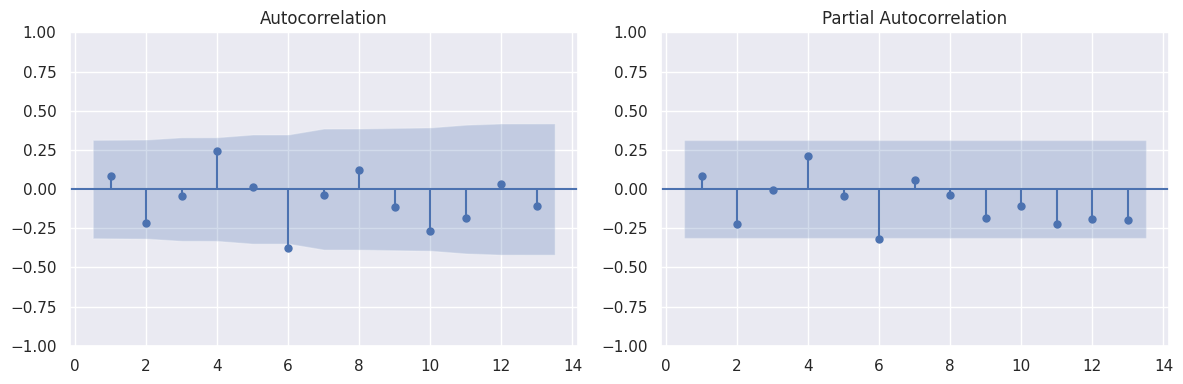


-------------------


In [ ]:
######Z1
model = qda.ARIMA(parts_final_df['z1'], order=(1,0,0), add_constant=False)
print(qda.ARIMAsummary(model))

#extract the residuals
residuals = model.resid[1:]

# Perform the Shapiro-Wilk test
_, pval_SW = stats.shapiro(residuals)
print('{}: Shapiro test p-value is {:.3f}'.format('residuals', pval_SW))

if pval_SW < alpha:
    print('Not Normal ❌')
else:
    print('Normal distribution ✅')

# Plot the qqplot
stats.probplot(residuals, dist="norm", plot=plt)
plt.show()

print('\n-------------------')

#LBQ
lbq_test = acorr_ljungbox(residuals , lags= 8 , return_df=True)
pval_lbq = lbq_test.loc[8,'lb_pvalue']

print('{}: LBQ test p-value is {:.3f}'.format('Z1', pval_lbq))
if pval_lbq < alpha:
    print('data are Autocorrolated ❌')
else:
    print('data are not Autocorrolated ✅')

fig, ax = plt.subplots(1,2 , figsize = (12, 4))
sgt.plot_acf(residuals, lags = int(len(residuals)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(residuals , lags = int(len(residuals)/3), zero=False, ax=ax[1], method = 'ywm')

plt.tight_layout()
plt.show()

print('\n-------------------')

residualsz1 = residuals

In [ ]:
####z2

model = qda.ARIMA(parts_final_df['z2'], order=(3,1,0), add_constant=False)
print(qda.ARIMAsummary(model))


#extract the residuals
residuals = model.resid[3:]

# Perform the Shapiro-Wilk test
_, pval_SW = stats.shapiro(residuals)
print('{}: Shapiro test p-value is {:.3f}'.format('residuals', pval_SW))

if pval_SW < alpha:
    print('Not Normal ❌')
else:
    print('Normal distribution ✅')

# Plot the qqplot
stats.probplot(residuals, dist="norm", plot=plt)
plt.show()

print('\n-------------------')

#LBQ
lbq_test = acorr_ljungbox(residuals , lags= 8 , return_df=True)
pval_lbq = lbq_test.loc[8,'lb_pvalue']

print('{}: LBQ test p-value is {:.3f}'.format('Z2', pval_lbq))
if pval_lbq < alpha:
    print('data are Autocorrolated ❌')
else:
    print('data are not Autocorrolated ✅')

fig, ax = plt.subplots(1,2 , figsize = (12, 4))
sgt.plot_acf(residuals, lags = int(len(residuals)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(residuals , lags = int(len(residuals)/3), zero=False, ax=ax[1], method = 'ywm')

plt.tight_layout()
plt.show()

print('\n-------------------')

residualsz2 = residuals

---------------------
ARIMA MODEL RESULTS
---------------------
ARIMA model order: p=3, d=1, q=0

FINAL ESTIMATES OF PARAMETERS
-------------------------------
 Term    Coef  SE Coef  T-Value    P-Value
ar.L1 -0.7058   0.1533  -4.6048 4.1287e-06
ar.L2 -0.7944   0.1544  -5.1455 2.6687e-07
ar.L3 -0.5133   0.1680  -3.0554 2.2473e-03

RESIDUAL SUM OF SQUARES
-------------------------
  DF      SS    MS
36.0 46.7264 1.298

Ljung-Box Chi-Square Statistics
----------------------------------
 Lag  Chi-Square  P-Value
  12      9.7791   0.6353
  24     16.7847   0.8577
  36     21.1542   0.9767
None


residuals: Shapiro test p-value is 0.275
Normal distribution ✅


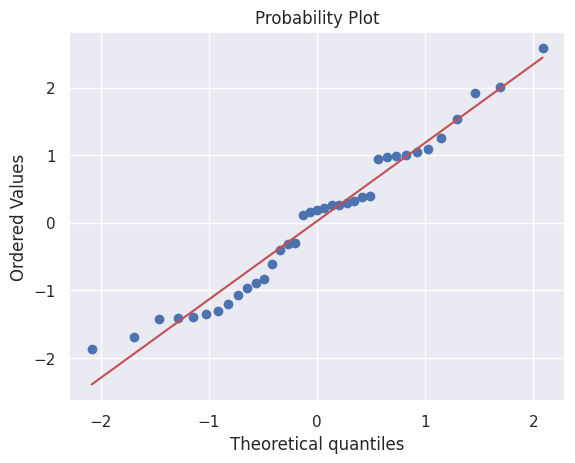


-------------------
Z2: LBQ test p-value is 0.743
data are not Autocorrolated ✅


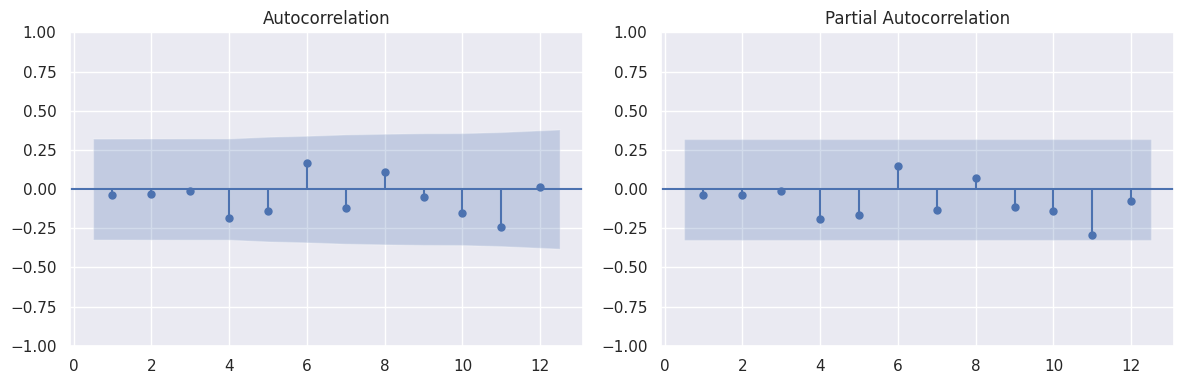


-------------------


# Results

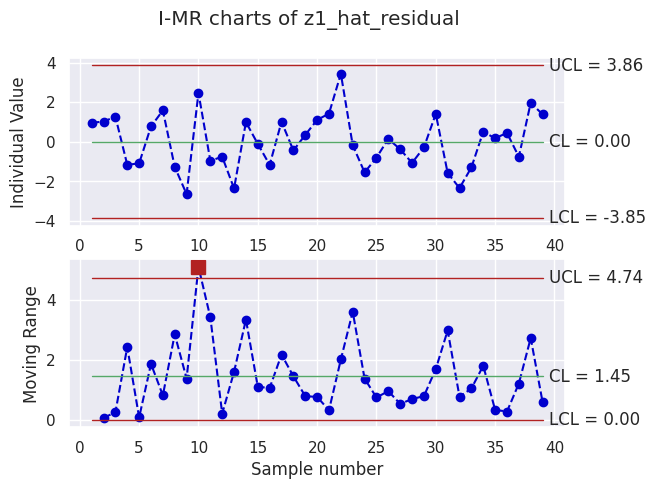

In [ ]:
residualsz1_df = pd.DataFrame(residualsz1, columns=['z1_hat_residual'])
#residualsz1_df.head()

#control chart
data_IMR = qda.ControlCharts.IMR(residualsz1_df, 'z1_hat_residual')

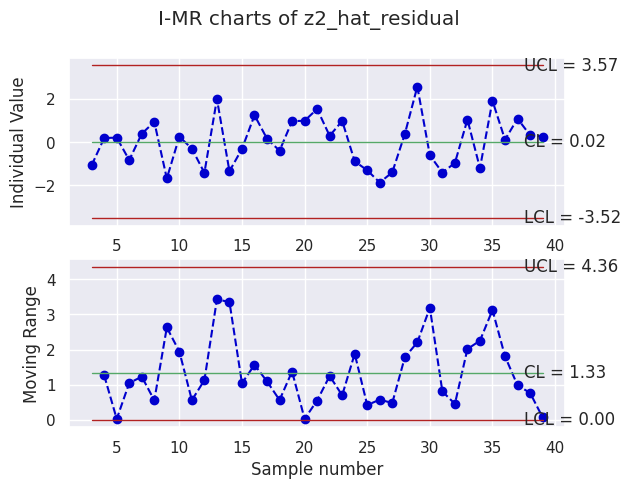

In [ ]:
residualsz2_df = pd.DataFrame(residualsz2, columns=['z2_hat_residual'])
#residualsz2_df.head()

#control chart
data_IMR = qda.ControlCharts.IMR(residualsz2_df, 'z2_hat_residual')

# References (if any)

### validating model by creating some defects by ourselves


In [ ]:
folder = '/content/drive/MyDrive/University |‌ دانشگاه/Masters - Polimi/AY23:24/Y 01/QDA Project/Defected'
new_df = image_to_statistics(folder ,folder)
new_df.set_index(['Image name', 'Position'], inplace=True)

new_df.head()

Region type  ID  \
Image name                                         Position                   
De_2024-03-26_14-12-21-094_MV540-H@xWyHvMbxwzDC... top_left        part   0   
                                                   top_left        void   1   
                                                   top_left        void   2   
                                                   top_left        void   3   
                                                   top_left        void   4   

                                                             Area [pixels]  \
Image name                                         Position                  
De_2024-03-26_14-12-21-094_MV540-H@xWyHvMbxwzDC... top_left          37277   
                                                   top_left            101   
                                                   top_left             83   
                                                   top_left            205   
                                                   top_left            203   

                                                             Perimeter [pixels]  \
Image name                                         Position                       
De_2024-03-26_14-12-21-094_MV540-H@xWyHvMbxwzDC... top_left            4282.502   
                                                   top_left              47.556   
                                                   top_left              34.971   
                                                   top_left              64.213   
                                                   top_left              74.770   

                                                             Eccentricity  \
Image name                                         Position                 
De_2024-03-26_14-12-21-094_MV540-H@xWyHvMbxwzDC... top_left         0.132   
                                                   top_left         0.939   
                                                   top_left         0.790   
                                                   top_left         0.893   
                                                   top_left         0.959   

                                                             Orientation [radians]  \
Image name                                         Position                          
De_2024-03-26_14-12-21-094_MV540-H@xWyHvMbxwzDC... top_left                 -0.408   
                                                   top_left                 -1.278   
                                                   top_left                 -1.245   
                                                   top_left                 -1.399   
                                                   top_left                 -1.232   

                                                             Solidity  Extent  \
Image name                                         Position                     
De_2024-03-26_14-12-21-094_MV540-H@xWyHvMbxwzDC... top_left     0.738   0.672   
                                                   top_left     0.863   0.534   
                                                   top_left     0.933   0.659   
                                                   top_left     0.919   0.607   
                                                   top_left     0.879   0.396   

                                                             Major Axis Length [pixels]  \
Image name                                         Position                               
De_2024-03-26_14-12-21-094_MV540-H@xWyHvMbxwzDC... top_left                     279.609   
                                                   top_left                      20.598   
                                                   top_left                      13.504   
                                                   top_left                      25.546   
                                                   top_left                      31.923   

                            

In [ ]:
new_parts =  new_df[new_df['ID'] == 0 ]
new_voids =  new_df[new_df['ID'] != 0 ]

new_parts_measures = new_parts[['Area [pixels]', 'Perimeter [pixels]']]
new_parts_measures.columns = ['Part_Area', 'Part_Perimeter']

new_s_voids_area = new_voids.groupby(['Image name', 'Position']).sum()['Area [pixels]']
new_s_voids_perimeter = new_voids.groupby(['Image name', 'Position']).sum()['Perimeter [pixels]']

new_parts_measures = new_parts_measures.merge(new_s_voids_area, how='left', on=('Image name', 'Position')).merge(new_s_voids_perimeter, how='left', on=('Image name', 'Position'))
new_parts_measures.columns =['Part_Area', 'Part_Perimeter', 'Voids_Area', 'Voids_Permeter']
parameters = ['Part_Area', 'Part_Perimeter', 'Voids_Area', 'Voids_Permeter' ,'#Voids']

print(new_parts_measures.shape)
new_parts_measures.head(8)

(8, 4)


Part_Area  \
Image name                                         Position                  
De_2024-03-26_14-12-21-094_MV540-H@xWyHvMbxwzDC... top_left          37277   
                                                   bottom_left       36965   
                                                   top_right         37639   
                                                   bottom_right      38247   
De_2024-03-26_14-19-57-558_MV540-H@xWyHvMbxwzDC... top_left          38254   
                                                   bottom_left       38543   
                                                   top_right         37029   
                                                   bottom_right      38558   

                                                                 Part_Perimeter  \
Image name                                         Position                       
De_2024-03-26_14-12-21-094_MV540-H@xWyHvMbxwzDC... top_left            4282.502   
                                                   bottom_left         4206.804   
                                                   top_right           4386.242   
                                                   bottom_right        4219.117   
De_2024-03-26_14-19-57-558_MV540-H@xWyHvMbxwzDC... top_left            4104.833   
                                                   bottom_left         4150.810   
                                                   top_right           4126.987   
                                                   bottom_right        4115.862   

                                                                 Voids_Area  \
Image name                                         Position                   
De_2024-03-26_14-12-21-094_MV540-H@xWyHvMbxwzDC... top_left           12815   
                                                   bottom_left        12492   
                                                   top_right          12312   
                                                   bottom_right       12145   
De_2024-03-26_14-19-57-558_MV540-H@xWyHvMbxwzDC... top_left           11919   
                                                   bottom_left        12082   
                                                   top_right          11547   
                                                   bottom_right       12030   

                                                                 Voids_Permeter  
Image name                                         Position                      
De_2024-03-26_14-12-21-094_MV540-H@xWyHvMbxwzDC... top_left            3128.048  
                                                   bottom_left         3083.162  
                                                   top_right           3194.816  
                                                   bottom_right        3048.976  
De_2024-03-26_14-19-57-558_MV540-H@xWyHvMbxwzDC... top_left            2960.554  
                                                   bottom_left         3010.083  
                                                   top_right           2964.246  
                                                   bottom_right        2953.585

In [ ]:
#We did boxcox, repeating it here again for data:
violating_measures = ['Part_Perimeter', 'Voids_Permeter']

# Apply the Box-Cox transformation to the new dataset using the stored lambdas and add columns to the new dataframe
for parameter in violating_measures:
    transformed_column = stats.boxcox(new_parts_measures[parameter], lmbda=lambdas[parameter])
    new_parts_measures[f'{parameter}_Normal'] = transformed_column

new_parts_measures.head()

Part_Area  \
Image name                                         Position                  
De_2024-03-26_14-12-21-094_MV540-H@xWyHvMbxwzDC... top_left          37277   
                                                   bottom_left       36965   
                                                   top_right         37639   
                                                   bottom_right      38247   
De_2024-03-26_14-19-57-558_MV540-H@xWyHvMbxwzDC... top_left          38254   

                                                                 Part_Perimeter  \
Image name                                         Position                       
De_2024-03-26_14-12-21-094_MV540-H@xWyHvMbxwzDC... top_left            4282.502   
                                                   bottom_left         4206.804   
                                                   top_right           4386.242   
                                                   bottom_right        4219.117   
De_2024-03-26_14-19-57-558_MV540-H@xWyHvMbxwzDC... top_left            4104.833   

                                                                 Voids_Area  \
Image name                                         Position                   
De_2024-03-26_14-12-21-094_MV540-H@xWyHvMbxwzDC... top_left           12815   
                                                   bottom_left        12492   
                                                   top_right          12312   
                                                   bottom_right       12145   
De_2024-03-26_14-19-57-558_MV540-H@xWyHvMbxwzDC... top_left           11919   

                                                                 Voids_Permeter  \
Image name                                         Position                       
De_2024-03-26_14-12-21-094_MV540-H@xWyHvMbxwzDC... top_left            3128.048   
                                                   bottom_left         3083.162   
                                                   top_right           3194.816   
                                                   bottom_right        3048.976   
De_2024-03-26_14-19-57-558_MV540-H@xWyHvMbxwzDC... top_left            2960.554   

                                                                 Part_Perimeter_Normal  \
Image name                                         Position                              
De_2024-03-26_14-12-21-094_MV540-H@xWyHvMbxwzDC... top_left                 7.1451e+60   
                                                   bottom_left              5.2674e+60   
                                                   top_right                1.0758e+61   
                                                   bottom_right             5.5373e+60   
De_2024-03-26_14-19-57-558_MV540-H@xWyHvMbxwzDC... top_left                 3.4627e+60   

                                                                 Voids_Permeter_Normal  
Image name                                         Position                             
De_2024-03-26_14-12-21-094_MV540-H@xWyHvMbxwzDC... top_left                 2.6528e+45  
                                                   bottom_left              2.1883e+45  
                                                   top_right                3.5145e+45  
                                                   bottom_right             1.8864e+45  
De_2024-03-26_14-19-57-558_MV540-H@xWyHvMbxwzDC... top_left                 1.2747e+45

In [ ]:
#transforming by PCA:
new_parameters = ['Part_Area', 'Part_Perimeter_Normal', 'Voids_Area', 'Voids_Permeter_Normal']
new_parts_measures_std = new_parts_measures[new_parameters]

#scaling
new_parts_measures_std = (new_parts_measures_std - new_parts_measures_std.mean())/ new_parts_measures_std.std()
new_parts_measures_std.describe()


,Part_Area,Part_Perimeter_Normal,Voids_Area,Voids_Permeter_Normal
count,8.0000,8.0000e+00,8.0000e+00,8.0000
mean,0.0000,-1.6653e-16,-5.5511e-17,0.0000
std,1.0000,1.0000e+00,1.0000e+00,1.0000
min,-1.2713,-8.1393e-01,-1.6270e+00,-0.8947
25%,-0.8969,-6.9611e-01,-4.3378e-01,-0.8258
50%,0.1932,-3.0145e-01,-1.4219e-01,-0.2694
75%,0.7670,1.8897e-01,4.9604e-01,0.4349
max,1.1140,2.1402e+00,1.6965e+00,1.9397


In [ ]:
# Compute the scores to the new data
new_scores = pca_std.transform(new_parts_measures_std)
# create a dataframe with the scores
new_scores_df = pd.DataFrame(new_scores, columns = ['z1', 'z2', 'z3', 'z4'])

new_parts_final_df = new_scores_df['z1']
new_parts_final_df

0   -2.0131
1   -1.1498
2   -2.3896
3    0.3794
4    1.4883
5    1.1429
6    0.9791
7    1.5627
Name: z1, dtype: float64

here is our previously fitted ARIMA:

      ---------------------
      ARIMA MODEL RESULTS
      ---------------------
      ARIMA model order: p=1, d=0, q=0

      FINAL ESTIMATES OF PARAMETERS
      -------------------------------
      Term   Coef  SE Coef  T-Value    P-Value
      ar.L1 0.6099   0.1265   4.8203 1.4333e-06

      RESIDUAL SUM OF SQUARES
      -------------------------
        DF      SS     MS
      39.0 86.8326 2.2265

      Ljung-Box Chi-Square Statistics
      ----------------------------------
      Lag  Chi-Square  P-Value
        12     16.6311   0.1640
        24     31.6531   0.1358
        36     35.5883   0.4880

In [ ]:

# AR(1) coefficient from the given model
ar1_coefficient = 0.6099

# Initialize predicted values array with zeros
predicted_values = np.zeros(len(new_parts_final_df))

# Use initial data to predict the new data
for t in range(1, len(new_parts_final_df)):
    predicted_values[t] = ar1_coefficient * new_parts_final_df[t-1]

# Calculate residuals
residuals = new_parts_final_df - predicted_values

# Create a DataFrame for easy visualization
new_residuals_df = pd.DataFrame({'z1_hat_residual': residuals})
new_residuals_df

,z1_hat_residual
0,-2.0131
1,0.0780
2,-1.6884
3,1.8368
4,1.2570
5,0.2352
6,0.2820
7,0.9656


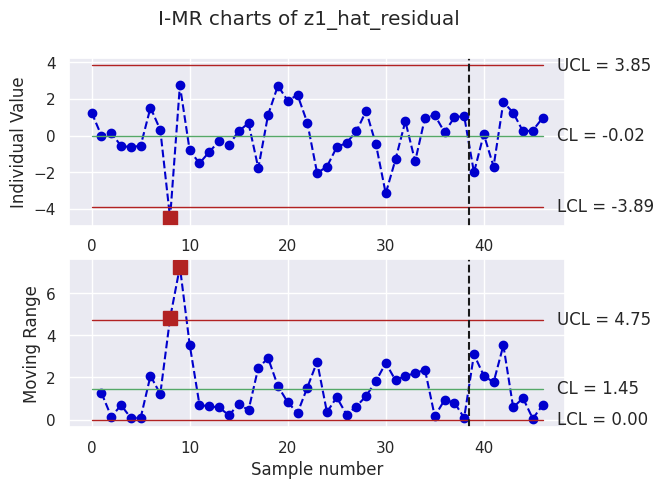

In [ ]:
concat_residuals = pd.concat([residuals_df, new_residuals_df], ignore_index=True)

#control chart
new_data_IMR = qda.ControlCharts.IMR(concat_residuals, 'z1_hat_residual' , subset_size=len(residuals_df))

Apparently it failedd


# PHASE 2 -----------------------------

# Preliminary data analysis

# Test of your proposed approach on new data

# Discussion

# TEMPERORY

In [ ]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/University |‌ دانشگاه/Masters - Polimi/AY23:24/Y 01/QDA Project/image_statistics.csv', index_col=['Image name', 'Position'])

parts =  df[df['ID'] == 0 ]
voids =  df[df['ID'] != 0 ]

df.head(50)

Region type  \
Image name                                         Position                  
2024-03-26_14-19-54-164_MV540-H@xWyHvMbxwzDCYCH... top_left           part   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   top_left           void   
                                                   bottom_left        part   
                                                   bottom_left        void   
                                                   bottom_left        void   
                                                   bottom_left        void   
                                                   bottom_left        void   
                                                   bottom_left        void   

      

In [ ]:
# Creating a 3x1 grid of subplots
fig, ax = plt.subplots(3, 1, figsize=(10, 8))

# Plotting scatter plots on each subplot with titles and labels

plt.plot(data=voids, x='Orientation [radians]', hue='Cluster',  ax=ax[0])
ax[0].set_title('Orientation Distribution')
ax[0].set_xlabel('Orientation [radians]')
ax[0].set_ylabel('Count')

ax[1].scatter(*voids['Area [pixels]'].value_counts().sort_index().reset_index().values.T)
ax[1].set_title('Area Distribution')
ax[1].set_xlabel('Area [pixels]')
ax[1].set_ylabel('Count')

ax[2].scatter(*voids['Perimeter [pixels]'].value_counts().sort_index().reset_index().values.T)
ax[2].set_title('Perimeter Distribution')
ax[2].set_xlabel('Perimeter [pixels]')
ax[2].set_ylabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout()

# Showing the plot
plt.show()

In [ ]:
a = df['Orientation [radians]'].groupby(level=['Image name', 'Position'])

c = df[df['ID']!= 0 ]
plt.scatter(*c['Orientation [radians]'].value_counts().sort_index().reset_index().values.T)

In [ ]:
c.describe(include ='all')
c['Orientation [radians]'].value_counts().sort_index().reset_index()

In [ ]:
from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='Orientation [radians]', y='count', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
statistic, p_value = shapiro(a['ID'])
print(f'Statistic = {statistic:.3f}, p-value = {p_value:.3f}')


alpha = 0.05
if p_value < alpha:
    print(f'Data of {parameter} does not follow normal distribution')
else:
    print(f'Data of {parameter} follows normal distribution')

[data_norm, lmbda] = stats.boxcox(a['ID'])


print('Lambda = %.3f' % lmbda)


statistic, p_value = shapiro(data_norm)
print(f'Statistic = {statistic:.3f}, p-value = {p_value:.3f}')



In [ ]:
# Assuming voids is your original DataFrame with 'Cluster' column
vtemp = voids.iloc[:, 2:-1]  # Assuming you're selecting specific columns for scaling
scaler1 = StandardScaler()
Void_scaled = scaler1.fit_transform(vtemp)

# Creating a DataFrame from the scaled data
void_scaled_df = pd.DataFrame(Void_scaled, columns=vtemp.columns)

# Resetting index of the original DataFrame voids
voids_reset_index = voids.reset_index(drop=True)

# Adding the 'Cluster' column to the scaled DataFrame
void_scaled_df['Cluster'] = voids_reset_index['Cluster']

# Plotting pairplot
sns.pairplot(void_scaled_df, diag_kind='kde', hue='Cluster')
plt.show()

In [ ]:
#Classification of Voids
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


cols = ['Area [pixels]', 'Perimeter [pixels]', 'Orientation [radians]']

X = voids[cols]
n_clusters = 5

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-Means clustering with an initial guess for the number of clusters
kmeans1 = KMeans( n_clusters , random_state=42, n_init=10 )
kmeans1.fit(X_scaled)

# Get the cluster centers and labels
centers = kmeans1.cluster_centers_
labels = kmeans1.labels_

# Print the cluster centers
print("Cluster Centers:")
print(centers)


# Add the cluster labels to the DataFrame
voids['Cluster'] = labels


# Function to plot the Elbow Method
def plot_elbow_method(X):
    wcss = []  # List to store within-cluster sum of squares (WCSS) for each number of clusters

    # Calculate WCSS for a range of cluster numbers
    for i in range(1, 20):
        kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)  # Inertia: Sum of squared distances to closest cluster center

    # Plot WCSS against the number of clusters
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 20), wcss, marker='o', linestyle='--')
    plt.title('Elbow Method For Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.show()

# Call the function to plot the Elbow Method
plot_elbow_method(X_scaled)


In [ ]:
plt.clf()
plt.scatter(voids['Area [pixels]'], voids['Perimeter [pixels]'], c=voids['Cluster'], cmap='viridis', alpha=0.3)

In [ ]:
#Classification of Voids
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler



cols = ['Area [pixels]', 'Perimeter [pixels]', 'Orientation [radians]',  'Major Axis Length [pixels]', 'Minor Axis Length [pixels]']

X = voids[cols]
n_clusters = 5

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-Means clustering with an initial guess for the number of clusters
kmeans2 = KMeans( n_clusters , random_state=42)
kmeans2.fit(X_scaled)

# Get the cluster centers and labels
centers = kmeans2.cluster_centers_
labels = kmeans2.labels_

# Print the cluster centers
print("Cluster Centers:")
print(centers)


# Add the cluster labels to the DataFrame
voids['Cluster'] = labels


# Function to plot the Elbow Method
def plot_elbow_method(X):
    wcss = []  # List to store within-cluster sum of squares (WCSS) for each number of clusters

    # Calculate WCSS for a range of cluster numbers
    for i in range(1, 20):
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)  # Inertia: Sum of squared distances to closest cluster center

    # Plot WCSS against the number of clusters
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 20), wcss, marker='o', linestyle='--')
    plt.title('Elbow Method For Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.show()

# Call the function to plot the Elbow Method
plot_elbow_method(X_scaled)


In [ ]:
plt.scatter(voids['Area [pixels]'], voids['Perimeter [pixels]'], c=voids['Cluster'], cmap='viridis', alpha=0.3)

# area , priemete exsit
#5 cluster

In [ ]:
#Classification of Voids
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler



cols = ['Area [pixels]', 'Perimeter [pixels]']

X = voids.loc[:, cols]
n_clusters = 5

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-Means clustering with an initial guess for the number of clusters
kmeans3 = KMeans( n_clusters , random_state=42, n_init=10)
kmeans3.fit(X_scaled)

# Get the cluster centers and labels
centers = kmeans3.cluster_centers_
labels = kmeans3.labels_

# Print the cluster centers
print("Cluster Centers:")
print(centers)


# Add the cluster labels to the DataFrame
voids['Cluster'] = labels


# Function to plot the Elbow Method
def plot_elbow_method(X):
    wcss = []  # List to store within-cluster sum of squares (WCSS) for each number of clusters

    # Calculate WCSS for a range of cluster numbers
    for i in range(1, 20):
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)  # Inertia: Sum of squared distances to closest cluster center

    # Plot WCSS against the number of clusters
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 20), wcss, marker='o', linestyle='--')
    plt.title('Elbow Method For Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.show()

# Call the function to plot the Elbow Method
plot_elbow_method(X_scaled)

plt.scatter(voids['Area [pixels]'], voids['Perimeter [pixels]'], c=voids['Cluster'], cmap='viridis', alpha=0.3)


In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Predict cluster labels for each model
labels1 = kmeans1.labels_
labels2 = kmeans2.labels_
labels3 = kmeans3.labels_


# Compute inertia for both models
inertia1 = kmeans1.inertia_
inertia2 = kmeans2.inertia_
inertia3 = kmeans3.inertia_

# Compute silhouette score for both models
silhouette1 = silhouette_score(X_scaled, labels1)
silhouette2 = silhouette_score(X_scaled, labels2)
silhouette3 = silhouette_score(X_scaled, labels3)

# Compute Davies-Bouldin index for both models
davies_bouldin1 = davies_bouldin_score(X_scaled, labels1)
davies_bouldin2 = davies_bouldin_score(X_scaled, labels2)
davies_bouldin3 = davies_bouldin_score(X_scaled, labels3)

# Print the results
print("KMeans with Area,P, O:")
print(f"Inertia: {inertia1}")
print(f"Silhouette Score: {silhouette1}")
print(f"Davies-Bouldin Index: {davies_bouldin1}")

print("\nKMeans with 5:") #['Area [pixels]', 'Perimeter [pixels]', 'Orientation [radians]',  'Major Axis Length [pixels]', 'Minor Axis Length [pixels]']
print(f"Inertia: {inertia2}")
print(f"Silhouette Score: {silhouette2}")
print(f"Davies-Bouldin Index: {davies_bouldin2}")

print("\nKMeans with only A,P:") #['Area [pixels]', 'Perimeter [pixels]']
print(f"Inertia: {inertia3}")
print(f"Silhouette Score: {silhouette3}")
print(f"Davies-Bouldin Index: {davies_bouldin3}")

Explanation:
1. Inertia: Lower inertia values indicate tighter clusters, which is usually better. Compare the inertia values of the two models.

2. Silhouette Score: This ranges from -1 to 1. Higher values indicate that the clusters are well-defined. Compare the silhouette scores to determine which model has better-defined clusters.

3. Davies-Bouldin Index: Lower values indicate better clustering as they imply that the clusters are compact and well-separated. Compare the Davies-Bouldin indices of the two models.


In [ ]:
# Assuming you have trained KMeans model named kmeans and new data named new_data

# Standardize the new data using the same scaler used for training data
new_data_scaled = scaler.transform(new_data)

# Predict cluster labels for new data points
new_data_cluster_labels = kmeans.predict(new_data_scaled)

# Add the cluster labels to the new data
new_data['Cluster'] = new_data_cluster_labels